In [1]:
!nvidia-smi

Wed Jan 18 06:12:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 29%   24C    P8     5W / 250W |  10248MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 30%   

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import datetime
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.adam import Adam

## Data 살펴보기

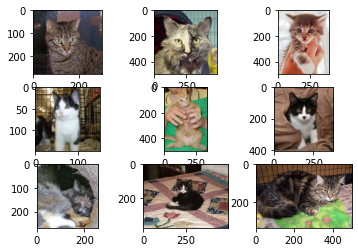

In [69]:
training_data = ImageFolder("./data/dogncat/training_set/training_set")
test_data = ImageFolder("./data/dogncat/test_set/test_set")

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(training_data[i][0])

plt.show()

In [68]:
# all_cat = []
# all_dog = []

# for i in range(len(training_data)):
#     item_image = training_data[i][0]
#     item_label = training_data[i][1]
    
#     if item_label == 1:
#         all_dog.append(item_image)
#     else :
#         all_cat.append(item_image)

In [83]:
import torchvision.transforms as T

from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transforms = Compose([ # ❶ 데이터 전처리 함수들
   T.ToPILImage(),
   RandomCrop((32, 32), padding=4), # ➋ 랜덤으로 이미지 일부 제거 후 패딩
   RandomHorizontalFlip(p=0.5),     # ➌ y축으로 기준으로 대칭
])

train_data = ImageFolder("./data/dogncat/training_set/training_set",transform=transforms)
test_data = ImageFolder("./data/dogncat/test_set/test_set",transform=transforms)

# for i in range(9):
#     plt.subplot(3, 3, i+1)
#     plt.imshow(transforms(train_data[i][0]))
# plt.show()

In [86]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, hidden_dim,
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels,
                               kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        return x

In [87]:
class CNN(nn.Module):
   def __init__(self, num_classes): # num_classes는 클래스의 개수를 의미합니다
       super(CNN, self).__init__()

       # ❶ 합성곱 기본 블록의 정의
       self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
       self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
       self.block3 = BasicBlock(in_channels=128, out_channels=256, 
                                hidden_dim=128)

       # ❷ 분류기 정의
       self.fc1 = nn.Linear(in_features=4096, out_features=2048)
       self.fc2 = nn.Linear(in_features=2048, out_features=256)
       self.fc3 = nn.Linear(in_features=256, out_features=num_classes)


       # ❸ 분류기의 활성화 함수
       self.relu = nn.ReLU()

   def forward(self, x):
       x = self.block1(x)
       x = self.block2(x)
       x = self.block3(x)  # 출력 모양: (-1, 256, 4, 4) 
       x = torch.flatten(x, start_dim=1) # ➍ 2차원 특징맵을 1차원으로

       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       x = self.relu(x)
       x = self.fc3(x)

       return x

In [89]:
# ❷ 데이터로더 정의
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


# ❸ 학습을 진행할 프로세서 설정
device = "cuda" if torch.cuda.is_available() else "cpu"


# ➍ CNN 모델 정의
model = CNN(num_classes=2)

# ➎ 모델을 device로 보냄
model.to(device)

CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

In [92]:
# ❶ 학습률 정의
lr = 1e-3

# ❷ 최적화 기법 정의
optim = Adam(model.parameters(), lr=lr)

# 학습 루프 정의
for epoch in range(100):
   for data, label in train_loader:  # ➌ 데이터 호출
       optim.zero_grad()  # ➍ 기울기 초기화

       preds = model(data.to(device))  # ➎ 모델의 예측

       # ➏ 오차역전파와 최적화
       loss = nn.CrossEntropyLoss()(preds, label.to(device)) 
       loss.backward() 
       optim.step() 

   if epoch==0 or epoch%10==9:  # 10번마다 손실 출력
       print(f"epoch{epoch+1} loss:{loss.item()}")


# 모델 저장
torch.save(model.state_dict(), "CatnDog.pth")

TypeError: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.

In [ ]:
model.load_state_dict(torch.load("CIFAR.pth", map_location=device))

num_corr = 0

with torch.no_grad():
   for data, label in test_loader:

       output = model(data.to(device))
       preds = output.data.max(1)[1]
       corr = preds.eq(label.to(device).data).sum().item()
       num_corr += corr

   print(f"Accuracy:{num_corr/len(test_data)}")